<div style="text-align:center;"><h1>데이터 과학 Term Project</h1></div><br><br>
<div style="text-align:right;">
        <ul style="list-style:none;">
            <li>2012120162 신준수</li>
            <li>2014120108 정하람</li>
            <li>2015410075 임경섭</li>
            <li>2016320206 김효정</li>
            <li>2016320221 김민재</li>
        </ul>
</div>

# 배달 주문량 예측


## Problem

  최근에 요식업 창업이 증가하고 배달 어플리케이션이 생겨나면서 배달음식에 대한 수요가 크게 증가하고 있다. 그러나 포화된 시장 속에서 개별적인 경쟁력을 갖추지 못해 폐업하는 비율도 상당하다. 이에 요식업에서 굉장히 중요한 이슈 중 하나인 '효율적인 재고 관리'를 위해 ‘배달 주문량을 예측’해보고자 한다. 날씨 데이터에만 의존했던 기존의 판매량 예측 모델과는 달리 다양한 특성들을 고려하여 보다 효과적인 모델을 설계해보고자 한다. 

## Expected Result

  정해진 feature들을 이용해 당일 배달 주문량을 적절한 오차 범위 내로 예측할  수 있는 모델을 구축해내는 것이 프로젝트의 최종 목표이다. 
적절한 feature 선정(축소)을 위해 우선 heatmap과 PCA를 활용할 예정이고 그 외에도 여러 모델을 활용해 분석을 마친 뒤 최종 예측을 위해서는 Neural Network모델을 활용하여 학습시키고자 한다. 
여기서 구축해낸 모델을 통해 자영업자들은 효율적인 재고관리라는 이점을 얻을 수 있고 배달앱의 수수료로 인해 배달앱과의 제휴를 꺼려하는 자영업자 및 소상공인들에게 제휴를 장려하도록 하여 배달 요식업계의 상생을 기대할 수 있다. 특히 배달 주문량의 데이터가 서울시에서만 기록되어 있는데 이 모델을 지방 업계에도 적용하여 적절한 평가를 진행하고 지역별 자영업 불균형을 해소하는 효과를 기대할 수 있다.

## 1. Data Load

1.target data: 

배달음식 주문량(skt 빅데이터 허브)

2.features: 

날씨 요인: 풍속, 강수량, 습도, 기온, 미세먼지(기상청)

경제 요인1: 기준금리(한국은행)

경제 요인2: 시가총액, 코스피지수, 체감 물가상승률(한국 거래소)

시간적 요인: 요일, 주말, 평일, 공휴일, 명절

## 1.1 Preprocessing

### 배달음식 주문량

-> 날짜별로 주문량 합산



### 주식데이터

-> 휴일의 nan값 : 

앞, 뒤 데이터의 평균 값을 넣는 방법과 앞, 뒤 데이터로 nan 값을 채우는 방법 두 가지 선택지가 있었다.

앞, 뒤 데이터로 nan 값을 채우는 것이 더 성능이 높게 나왔기에 이 방법을 선택하였고, 이는 주말의 이슈가 주식시장에 선행되어 반영되거나 장이 열린 후에 반영되는 경향으로 설명되는 것으로 보였다.

(토요일엔 금요일 데이터로, 일요일엔 월요일 데이터로)


### 날씨 데이터

-> 강수량이나 적설량의 경우 관측되는 일수가 현저히 적고, 강수량과 적설량이 관측되지 않았기에 nan값으로 둔 것으로 보여 nan값을 0으로 채웠다.

### 데이터 통합
 
-> 전처리를 수행한 후에 날짜를 기준으로 모든 데이터를 통합하여 하나의 데이터 프레임으로 만들었다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import robust_scale
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score, mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import normalize

In [2]:
data = pd.read_csv('raw_data2.csv', engine='python')
data = data.set_index('일자')
data_index = pd.to_datetime(data.index, infer_datetime_format = True)
data = data.reindex(data_index)

In [3]:
data.head()

,통화건수,한국은행 기준금리,지점,평균기온(°C),최저기온(°C),최고기온(°C),일강수량(mm),최대 순간 풍속(m/s),평균 풍속(m/s),평균 상대습도(%),1시간 최다일사량(MJ/m2),일 최심신적설(cm),KOSPI지수,KOSDAQ지수
일자,,,,,,,,,,,,,,
2013-12-01,62631,2.5,108,4.5,1.4,8.6,0.0,6.9,2.1,66.9,1.57,0.0,2030.78,512.69
2013-12-02,35513,2.5,108,3.9,0.1,6.6,0.0,5.2,1.4,64.3,0.53,0.0,2030.78,512.69
2013-12-03,38600,2.5,108,6.7,4.5,9.9,0.0,7.7,1.6,62.6,1.29,0.0,2009.36,508.16
2013-12-04,40319,2.5,108,5.5,2.1,9.6,0.0,6.2,1.8,72.8,1.28,0.0,1986.80,506.28
2013-12-05,42425,2.5,108,5.5,2.1,9.0,0.0,6.9,2.4,73.4,0.87,0.0,1984.77,506.32


## 2. Feature Selection / Engineering

### 2.1 Heatmap  

Feature가 과도하게 많아지면 데이터 또한 많이 필요해지고 overfitting의 위험이 커지는 등의 차원의 저주가 발생할 수 있다. 

이를 방지하고 모델의 Feature중에서 데이터의 특성을 가장 잘 나타내는 주요 필드를 선택하기 위해 Heatmap을 사용했다.

Heatmap의 결과를 보고 독립변수인 주문량(통화건수)과 연관성이 낮은 4가지 feature('지점', '최저기온(°C)', '최고기온(°C)', '최대 순간 풍속(m/s)')를 제거했다.

In [4]:
# 사용가능한 시스템의 TTF 폰트 목록
import matplotlib.font_manager as font_manager

font_list = font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

print('사용가능한 TTF 폰트 개수:', len(font_list))
font_list[:5] # 목록에서 처음 10 개만 보기

사용가능한 TTF 폰트 개수: 741


['C:\\WINDOWS\\Fonts\\LTYPEO.TTF',
 'C:\\WINDOWS\\Fonts\\ANTQUABI.TTF',
 'C:\\Windows\\Fonts\\phagspab.ttf',
 'C:\\WINDOWS\\Fonts\\georgiab.ttf',
 'C:\\Windows\\Fonts\\JOKERMAN.TTF']

In [5]:
#font_path = 'C:/Windows/Fonts/EBS훈민정음R.ttf'
#fontprop = fm.FontProperties(fname=font_path, size=18)

#plt.ylabel('가격', fontproperties=fontprop)
#plt.title('가격변동 추이', fontproperties=fontprop)

def Heatmap():
    fontprop = font_manager.FontProperties(fname="NanumBarunpenB.ttf", size=24)
    font_fname =  'C:\\WINDOWS\\Fonts\\NanumBarunpenB.ttf'
    font_family = font_manager.FontProperties(fname=font_fname).get_name()

    plt.rcParams["font.family"] = font_family
    #plt.rcParams["font.family"] = 'NanumBarunpenB'
    plt.rcParams["font.size"] = 5
    #plt.rcParams["figure.figsize"] = (15,4)

    # 그래프의 크기 지정
    plt.figure(figsize=(8, 8))

    # Heatmap 설정
    sns.heatmap(data.corr(), linewidths=0.1, vmax=0.5, cmap=plt.cm.gist_heat,
            linecolor='white', annot=True)

    # 렌더링
    #plt.legend()
    #plt.legend(prop={'family':'NanumBarunpenB', 'size':20})
    #plt.ylabel(data.columns,fontproperties=fontprop)
    plt.show()

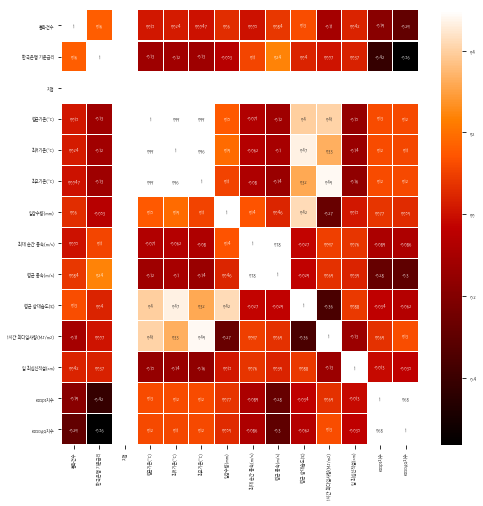

In [6]:
Heatmap()

In [7]:
#연관성 적은 4개 제거
data = data.drop(columns = ['지점', '최저기온(°C)', '최고기온(°C)', '최대 순간 풍속(m/s)'])

## 2.2: Add Weekday Data

 주말인지 평일인지, 무슨 요일인지에 따라 배달 주문량에 변화가 있을 것으로 판단해 one_hot_encoding 방식을 사용해 Feature에 Weekday Data를 추가했다.

In [8]:
day_of_week = pd.Series([x.weekday() for x in data.index], index = data.index)
day_dummies = pd.get_dummies(day_of_week, prefix='weekday', drop_first=False)
data = pd.concat([data, day_dummies], axis=1)

## 2.3: Add Previous week Data

### Base Feature

기존의 주문량 예측 모델, 예측 성공률 50%, 평균 주문량 등 무엇을 Base Model로 정하는 것이 가장 좋을지 협의했다.

해당날짜의 1~7일 전의 평균 주문량과 일주일 전 같은요일 주문량을 Base Model로 정했다. 

선택하게 된 이유는 연속적 성질을 지니고 있는 날씨, 경제적, 시간적 요인을 잘 설명해줄 수 있으며 직관적이기 때문이다.

In [9]:
target_data = data['통화건수']

prev_week_avg_list = [np.nan] * 7
prev_week = [np.nan] * 7
for idx in range(7, len(target_data)):
    avg = target_data.iloc[idx-7:idx].mean()
    prev_week_avg_list.append(avg)
    prev_week.append(target_data.iloc[idx-7])
    
prev_week_avg = pd.Series(prev_week_avg_list, index = data.index)
prev_week = pd.Series(prev_week, index=data.index)
prev_week_avg_fill = prev_week_avg.fillna(method='bfill')

data = pd.concat([data, pd.DataFrame(prev_week_avg_fill, columns=['prev_week_avg'])], axis=1)

## 2.4: Add Holiday Data

공휴일과 명절에는 배달 주문량이 평소와는 다르게 관측될 것이라고 판단해 one_hot_encoding 방식을 사용해 Feature에 공휴일, 명절 Data를 추가했다.

In [10]:
data = data.loc['2014-01-01':]
years = pd.read_csv('공휴일/'+str(2014)+' 공휴일.csv', engine='python',error_bad_lines=False, sep=',')
for year in range(2015, 2020):
    indiv_year = pd.read_csv('공휴일/'+str(year)+' 공휴일.csv', engine='python',error_bad_lines=False, sep=',')
    years = pd.concat([years, indiv_year])

years = years.set_index('holyday_array')
years = years.drop('Unnamed: 0', axis=1)

holiday = pd.Series([1 for x in years.index], index = years.index)
myungjul = pd.Series([(1 if x in ['설날', '추석'] else 0) for x in years['holyday_name_array']], index=years.index)

holiday_index = pd.to_datetime(holiday.index, infer_datetime_format = True)
holiday = pd.Series(data = holiday, index = holiday_index)
myungjul = pd.Series(data = myungjul, index = holiday_index)

holiday = holiday[holiday_index.duplicated()==False].reindex(data.index, fill_value=0)
myungjul = myungjul[holiday_index.duplicated()==False].reindex(data.index, fill_value=0)

data = pd.concat([data, pd.DataFrame(holiday, columns=['holiday']), pd.DataFrame(myungjul, columns=['myungjul'])], axis=1)

In [11]:
data['2019-02-01':].head()

,통화건수,한국은행 기준금리,평균기온(°C),일강수량(mm),평균 풍속(m/s),평균 상대습도(%),1시간 최다일사량(MJ/m2),일 최심신적설(cm),KOSPI지수,KOSDAQ지수,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,prev_week_avg,holiday,myungjul
일자,,,,,,,,,,,,,,,,,,,,
2019-02-01,39948,1.75,-2.1,0.3,1.7,47.6,2.04,0.0,2203.46,716.92,0,0,0,0,1,0,0,35375.857143,0,0
2019-02-02,37267,1.75,1.4,0.0,1.0,60.0,0.83,0.0,2203.46,716.92,0,0,0,0,0,1,0,34962.714286,0,0
2019-02-03,34189,1.75,3.3,16.0,1.7,92.9,0.10,0.0,2203.46,716.92,0,0,0,0,0,0,1,34179.857143,0,0
2019-02-04,20200,1.75,-0.6,0.0,2.1,40.4,2.16,0.0,2203.46,716.92,1,0,0,0,0,0,0,33410.142857,1,0
2019-02-05,13188,1.75,2.8,0.0,1.0,37.1,2.05,0.0,2203.46,716.92,0,1,0,0,0,0,0,32239.000000,1,1


## 3. Data Normalization / Standardization


데이터 프레임의 컬럼에 따라 value의 범위가 크게 차이나기에 특정 컬럼에 편향된 결과가 나올 수 있기에 이를 방지하기 위해 데이터 정규화를 수행했다.

min_max 정규화와 Z_score 정규화 두 가지 방법을 사용해 정규화를 수행했다.


### Data split

train set은 13~16년 data를, validation set은 17년 data를, test set은 18년 data를 사용했다.

In [12]:
train = data[:'2016-12-31']
valid = data['2017-01-01':'2017-12-31']
test = data['2018-01-01':'2018-12-31']

# normalize the validation/test set using min & max of the training set
def normalize_set(df_train, df_new):
    ret = pd.DataFrame(index=df_new.index, columns=df_new.columns)
    trainset_max = df_train.max()
    trainset_min = df_train.min()
    for col_name in df_train.columns :
        ret.loc[:,col_name] = (df_new[col_name] - trainset_min[col_name]) / (trainset_max[col_name] - trainset_min[col_name])
    return ret

# zscore the validation/test set using the mean & standard deviation of the training set
def zscore_set(df_train, df_new):
    ret = pd.DataFrame(index=df_new.index, columns=df_new.columns)
    trainset_mean = df_train.mean()
    trainset_std = df_train.std()
    for col_name in df_train.columns :
        ret.loc[:,col_name] = (df_new[col_name] - trainset_mean[col_name]) / trainset_std[col_name]
    return ret

In [13]:
train.head()

,통화건수,한국은행 기준금리,평균기온(°C),일강수량(mm),평균 풍속(m/s),평균 상대습도(%),1시간 최다일사량(MJ/m2),일 최심신적설(cm),KOSPI지수,KOSDAQ지수,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,prev_week_avg,holiday,myungjul
일자,,,,,,,,,,,,,,,,,,,,
2014-01-01,55628,2.5,4.0,0.0,3.7,51.3,1.13,0.0,2011.34,499.99,0,0,1,0,0,0,0,57762.857143,1,0
2014-01-02,38344,2.5,1.5,0.0,2.0,35.4,1.60,0.0,1967.19,496.28,0,0,0,1,0,0,0,55670.285714,0,0
2014-01-03,44865,2.5,2.3,0.0,2.5,54.4,1.22,0.0,1946.14,499.33,0,0,0,0,1,0,0,55343.142857,0,0
2014-01-04,57280,2.5,-0.1,0.0,2.4,47.1,1.46,0.0,1946.14,499.33,0,0,0,0,0,1,0,54632.571429,0,0
2014-01-05,56907,2.5,-0.8,0.0,1.9,48.4,1.29,0.0,1946.14,499.33,0,0,0,0,0,0,1,53712.857143,0,0


In [14]:
zscore_set(train,train).head()

,통화건수,한국은행 기준금리,평균기온(°C),일강수량(mm),평균 풍속(m/s),평균 상대습도(%),1시간 최다일사량(MJ/m2),일 최심신적설(cm),KOSPI지수,KOSDAQ지수,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,prev_week_avg,holiday,myungjul
일자,,,,,,,,,,,,,,,,,,,,
2014-01-01,0.514949,1.572357,-0.910308,-0.277156,1.388865,-0.636462,-1.090079,-0.102772,0.316504,-1.863331,-0.407193,-0.407193,2.444470,-0.408713,-0.408713,-0.408713,-0.407193,0.965818,4.722159,-0.074159
2014-01-02,-0.669197,1.572357,-1.148896,-0.277156,-0.636599,-1.721658,-0.449475,-0.102772,-0.460344,-1.916493,-0.407193,-0.407193,-0.408713,2.444470,-0.408713,-0.408713,-0.407193,0.756157,-0.211574,-0.074159
2014-01-03,-0.222436,1.572357,-1.072548,-0.277156,-0.040875,-0.424883,-0.967411,-0.102772,-0.830733,-1.872788,-0.407193,-0.407193,-0.408713,-0.408713,2.444470,-0.408713,-0.407193,0.723380,-0.211574,-0.074159
2014-01-04,0.628129,1.572357,-1.301592,-0.277156,-0.160020,-0.923118,-0.640293,-0.102772,-0.830733,-1.872788,-0.407193,-0.407193,-0.408713,-0.408713,-0.408713,2.444470,-0.407193,0.652186,-0.211574,-0.074159
2014-01-05,0.602574,1.572357,-1.368397,-0.277156,-0.755744,-0.834391,-0.872001,-0.102772,-0.830733,-1.872788,-0.407193,-0.407193,-0.408713,-0.408713,-0.408713,-0.408713,2.453598,0.560037,-0.211574,-0.074159


In [15]:
train_z = zscore_set(train, train)
valid_z = zscore_set(train, valid)
test_z = zscore_set(train, test)

In [16]:
train_n = normalize_set(train, train)
valid_n = normalize_set(train, valid)
test_n = normalize_set(train, test)

## 4. Feature Extraction

앞서 Feature selection을 이용해 Feature의 수를 감소시켰다. 

이번 단계에서는 Feature Extraction을 이용해 선정된 Feature 중에서 데이터를 설명하는데 큰 비중을 차지하고 있는 Feature를 찾아냈다.

이를 위해 PCA 분석을 실행했다.

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(data)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [18]:
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def PCA_model(df,n):
    norm_df = normalize(df)     #normalizing
    pca = PCA(n_components=n) #n => the number of dimension for decomposing
    pca.fit(norm_df)
    df_pca = pd.DataFrame(pca.transform(norm_df),columns=df.columns, index=df.index)
    return df_pca

def normalize(data):
    normalized_data = ((data - data.mean()) / (data.max() - data.min()))
    return normalized_data

def correlation(data):
    corr = data.corr()
    sns.set(style="white")
    f, ax = plt.subplots(figsize=(11,9))
    cmap = sns.diverging_palette(220,10,as_cmap=True)
    sns.heatmap(corr, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5,
                cbar_kws={"shrink": .5})

In [19]:
PCA_model(data, 20).head()

,통화건수,한국은행 기준금리,평균기온(°C),일강수량(mm),평균 풍속(m/s),평균 상대습도(%),1시간 최다일사량(MJ/m2),일 최심신적설(cm),KOSPI지수,KOSDAQ지수,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,prev_week_avg,holiday,myungjul
일자,,,,,,,,,,,,,,,,,,,,
2014-01-01,0.771448,-0.492857,-0.050698,-0.412403,0.497085,0.576051,-0.023549,-0.154356,-0.170662,0.178951,0.933568,0.186501,0.118701,-0.066865,-0.124738,-0.128060,-0.038140,-0.006844,0.028375,1.761307e-16
2014-01-02,0.720202,-0.427736,-0.018966,0.762480,-0.292392,0.396307,-0.010210,-0.130073,-0.278370,0.137905,-0.053177,0.121699,-0.215040,-0.108760,-0.096103,0.015184,0.034995,-0.002733,0.091341,-7.663143e-18
2014-01-03,0.842394,-0.096263,0.700201,-0.327569,-0.482012,0.041436,-0.036517,-0.199384,-0.042793,0.209821,-0.052060,0.061705,-0.091299,-0.087652,-0.043988,0.030326,-0.012745,-0.020381,0.094721,-1.738197e-16
2014-01-04,0.970475,0.346245,0.217040,0.319756,0.544728,-0.246913,-0.040369,-0.183416,-0.190483,0.165894,-0.041660,0.080195,-0.106898,-0.080709,-0.030030,0.017701,0.013675,-0.017608,0.064165,-1.244290e-16
2014-01-05,0.926413,0.296258,-0.646841,-0.222965,-0.378805,0.079011,-0.015694,-0.198653,-0.192789,0.177621,-0.034479,0.069943,-0.174834,-0.083239,-0.020742,0.008692,0.008775,-0.015703,0.046093,-1.648383e-16


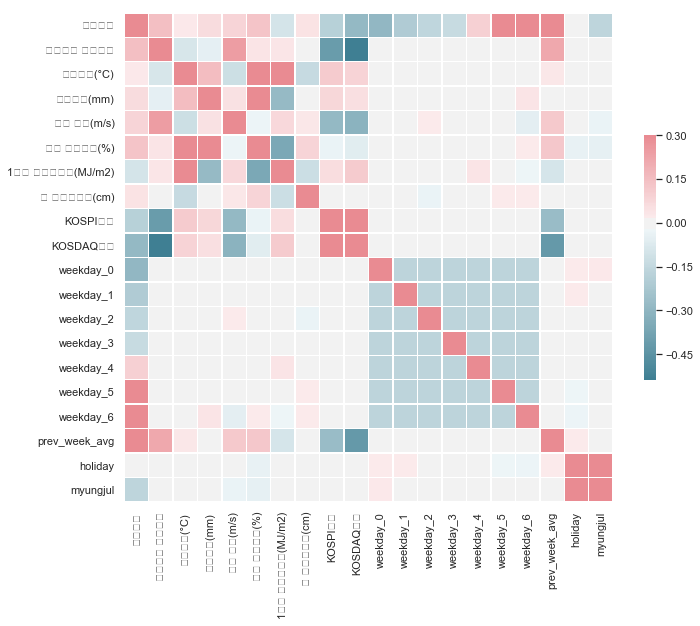

In [20]:
correlation(data)

## Base Model: Last Week Data

In [21]:
prev_week = prev_week.loc['2014-01-01':]
prediction = prev_week.loc['2018-01-01':'2018-12-31']

test_ev = explained_variance_score(data['통화건수'].loc['2018-01-01':'2018-12-31'], prediction)
print("testing set score: {:.3f}".format(test_ev))

testing set score: 0.263


## Base Model: Last Week Average

In [22]:
prediction = data['prev_week_avg'].loc['2018-01-01':'2018-12-31']

test_ev = explained_variance_score(data['통화건수'].loc['2018-01-01':'2018-12-31'], prediction)
print("testing set score: {:.3f}".format(test_ev))

testing set score: 0.081


첫 번째 Base Model은 지난 주 목표일의 통화건수가 이번 주 목표일의 데이터 동일하다고 판단한 모델이다.

Score는 0.263 이다.

두 번째 Base Model은 지난 주 통화건수의 평균이 이번 주 목표일의 데이터와 동일하다고 판단하는 모델이다.

Score는 0.081 이다.

이 후, 네 가지 모델로 나누어 학습을 진행하였다. 첫 번째 모델은 Linear Regression이다.

## Model 1-1: Linear Regression
여기선 위에서 전처리가 완료된 Dataset을 이용하여 예측 모델을 학습시키고 그 결과를 도출해냈다.

먼저, 학습된 예측 모델의 성능의 실효성을 검증하기 위해 단순 데이터를 이용한 Base Model을 생성하였다.

이 때, 각 모델의 성능을 측정하기 위한 수치인 score는 Explained Variance Score를 이용하였다.

Score는 0부터 1사이의 실수값을 가지며 1에 가까울수록 좋은 성능을 가진 모델이라고 할 수 있다.

In [23]:
x_train = train_z.drop(columns = ['통화건수'])
y_train = train_z['통화건수']

x_valid = valid_z.drop(columns = ['통화건수'])
y_valid = valid_z['통화건수']

model = LinearRegression()

reg = model.fit(x_train, y_train)

prediction = model.predict(x_valid)
prediction = pd.Series(data = prediction, index = y_valid.index)

아래 목록은 위에서부터 선형 모델의 각 feature들의 가중치와 마지막으로 선형 모델의 절편값을 나타낸 것이다.

In [ ]:
coef = pd.Series(data = model.coef_, index = x_train.columns)
print(coef.to_string(float_format = (lambda x: "{:.3f}".format(x))))
print(model.intercept_)

한국은행 기준금리                      -0.018
평균기온(°C)                       -0.004
일강수량(mm)                        0.067
평균 풍속(m/s)                      0.023
평균 상대습도(%)                      0.016
1시간 최다일사량(MJ/m2)               -0.007
일 최심신적설(cm)                     0.016
KOSPI지수                         0.025
KOSDAQ지수                       -0.033
weekday_0          -7318132951292.092
weekday_1          -7318132951292.016
weekday_2          -7337644917114.089
weekday_3          -7337644917114.057
weekday_4          -7337644917113.883
weekday_5          -7337644917113.627
weekday_6          -7318132951291.540
prev_week_avg                   0.628
holiday                         0.057
myungjul                       -0.150
0.001318235081178838


다음은 training set에 대한 모델의 score와 validation set에 대한 score를 각각 나타낸 것이다.

In [ ]:
train_ev = explained_variance_score(y_train, model.predict(x_train))
print("training set score: {:.3f}".format(train_ev))
test_ev = explained_variance_score(y_valid, prediction)
print("validation set score: {:.3f}".format(test_ev))

training set score: 0.815
validation set score: 0.684


그리고 학습된 모델이 예측한 결과와 실제 결과를 위에서부터 차례대로 training set, validation set에 대해 그래프로 표현하였다.

prediction 그래프가 학습한 모델이 예측한 결과를 나타낸 그래프이고 target 그래프는 실제 데이터의 그래프이다.

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


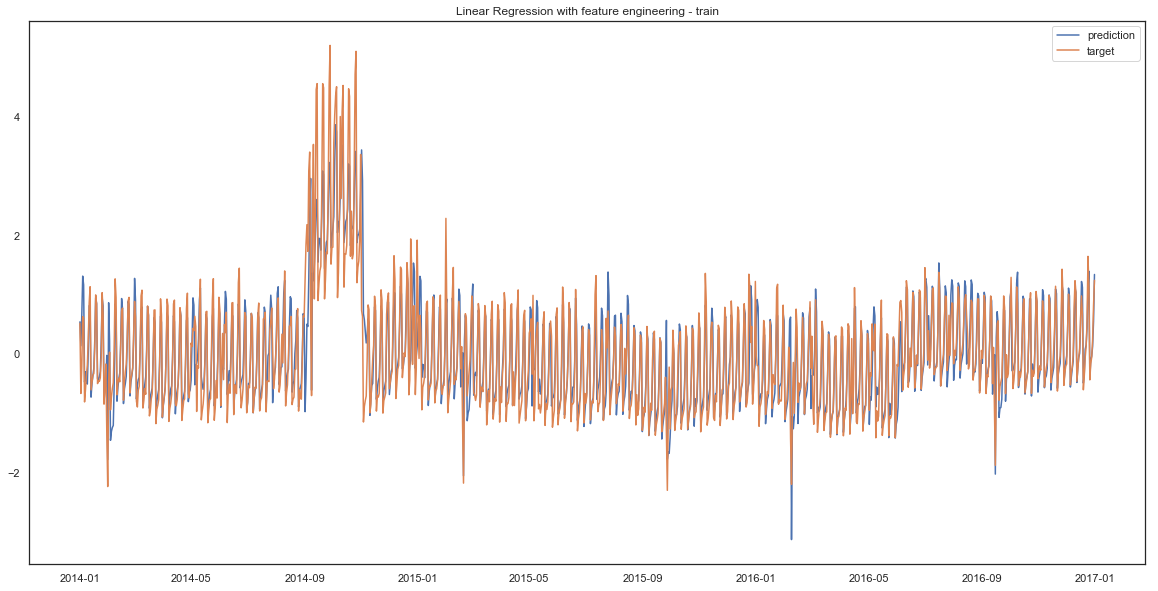

In [ ]:
prediction_train = pd.Series(data = model.predict(x_train), index = y_train.index)
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(1,1,1)
ax.plot(prediction_train, label='prediction')
ax.plot(y_train, label='target')
ax.set_title('Linear Regression with feature engineering - train')
ax.legend()

plt.show()

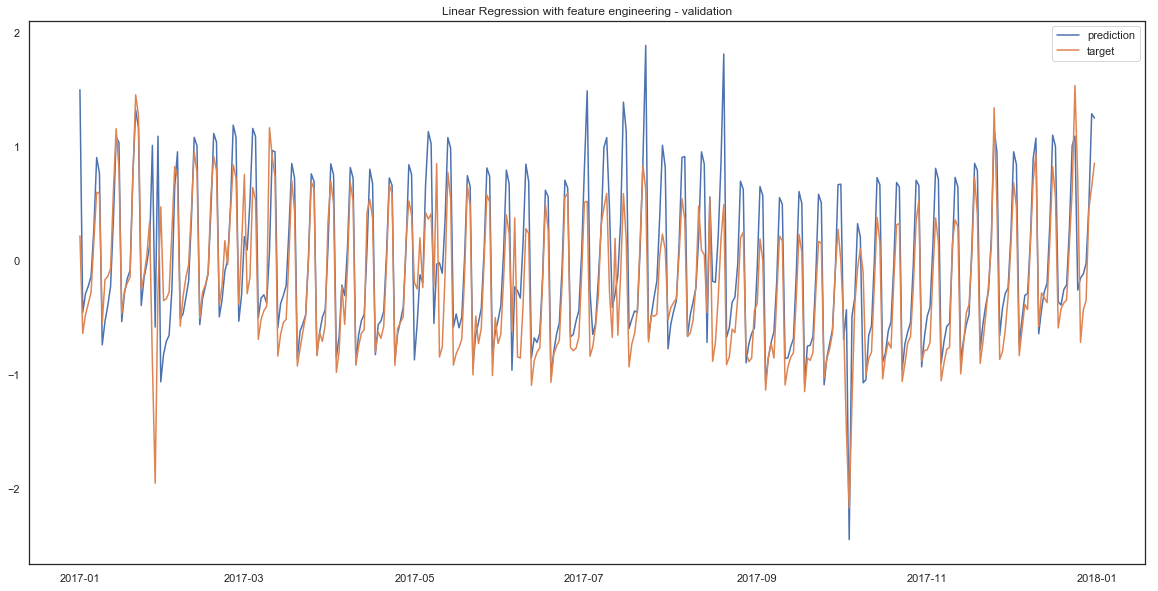

In [ ]:
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(1,1,1)
ax.plot(prediction, label='prediction')
ax.plot(y_valid, label='target')
ax.set_title('Linear Regression with feature engineering - validation')
ax.legend()

plt.show()

마지막으로 실제 데이터와 예측 데이터 사이의 Mean Squared Error를 계산하여 출력하였다.

In [ ]:
mse = mean_squared_error(y_valid, prediction)
mse

0.14082704126787418

Linear Regression의 경우, 가장 기초적이고 단순하지만 강력하고 전통적인 예측 모델 중 하나이다.

Training set score는 0.815, validation set score는 0.684로 준수한 성능을 내는 것을 알 수 있다.

Validation set에서의 예측 그래프를 보면 통화건수의 경향과 하락폭 등을 잘 예측해낸 것을 볼 수 있다.

그러나 통화건수가 상승하는 기간의 경우, 상대적으로 높은 예측값을 낸 것을 알 수 있다.

통화건수가 상승하는 기간은 주말근처로, 주말에는 주로 전화주문을 통해서 자택에서 배달을 해서 식사를 하기 때문에

상대적으로 높은 통화건수를 기록하게 되는 것이다. Linear Regression의 경우, 이 weekday에 대한 민감도가

높다라는 것을 validation set 그래프를 통해 알 수 있다.


다음 모델은 Ridge Regression이다.

## Model 1-2: Ridge Regression

1. alpha값 조정

In [ ]:
#alpha=5
from sklearn.linear_model import Ridge, Lasso
model_ridge = Ridge(alpha=5)

reg_ridge = model_ridge.fit(x_train, y_train)

prediction = model_ridge.predict(x_valid)
prediction = pd.Series(data = prediction, index = y_valid.index)

train_ev = explained_variance_score(y_train, model_ridge.predict(x_train))
print("training set score: {:.3f}".format(train_ev))
test_ev = explained_variance_score(y_valid, prediction)
print("validation set score: {:.3f}".format(test_ev))

training set score: 0.815
validation set score: 0.687


In [ ]:
#alpha=7

model_ridge = Ridge(alpha=7)

reg_ridge = model_ridge.fit(x_train, y_train)

prediction = model_ridge.predict(x_valid)
prediction = pd.Series(data = prediction, index = y_valid.index)

train_ev = explained_variance_score(y_train, model_ridge.predict(x_train))
print("training set score: {:.3f}".format(train_ev))
test_ev = explained_variance_score(y_valid, prediction)
print("validation set score: {:.3f}".format(test_ev))

training set score: 0.815
validation set score: 0.688


In [ ]:
#alpha=10

model_ridge = Ridge(alpha=10)

reg_ridge = model_ridge.fit(x_train, y_train)

prediction = model_ridge.predict(x_valid)
prediction = pd.Series(data = prediction, index = y_valid.index)

train_ev = explained_variance_score(y_train, model_ridge.predict(x_train))
print("training set score: {:.3f}".format(train_ev))
test_ev = explained_variance_score(y_valid, prediction)
print("validation set score: {:.3f}".format(test_ev))

training set score: 0.815
validation set score: 0.689


In [ ]:
#alpha=15

model_ridge = Ridge(alpha=15)

reg_ridge = model_ridge.fit(x_train, y_train)

prediction = model_ridge.predict(x_valid)
prediction = pd.Series(data = prediction, index = y_valid.index)

train_ev = explained_variance_score(y_train, model_ridge.predict(x_train))
print("training set score: {:.3f}".format(train_ev))
test_ev = explained_variance_score(y_valid, prediction)
print("validation set score: {:.3f}".format(test_ev))

training set score: 0.815
validation set score: 0.691


In [ ]:
#alpha=20

model_ridge = Ridge(alpha=20)

reg_ridge = model_ridge.fit(x_train, y_train)

prediction = model_ridge.predict(x_valid)
prediction = pd.Series(data = prediction, index = y_valid.index)

train_ev = explained_variance_score(y_train, model_ridge.predict(x_train))
print("training set score: {:.3f}".format(train_ev))
test_ev = explained_variance_score(y_valid, prediction)
print("validation set score: {:.3f}".format(test_ev))

training set score: 0.815
validation set score: 0.693


In [ ]:
#alpha=40

model_ridge = Ridge(alpha=40)

reg_ridge = model_ridge.fit(x_train, y_train)

prediction = model_ridge.predict(x_valid)
prediction = pd.Series(data = prediction, index = y_valid.index)

train_ev = explained_variance_score(y_train, model_ridge.predict(x_train))
print("training set score: {:.3f}".format(train_ev))
test_ev = explained_variance_score(y_valid, prediction)
print("validation set score: {:.3f}".format(test_ev))

training set score: 0.814
validation set score: 0.700


In [ ]:
coef = pd.Series(data = model_ridge.coef_, index = x_train.columns)
print(coef.to_string(float_format = (lambda x: "{:.3f}".format(x))))
print(model_ridge.intercept_)

한국은행 기준금리          -0.017
평균기온(°C)            0.002
일강수량(mm)            0.062
평균 풍속(m/s)          0.020
평균 상대습도(%)          0.017
1시간 최다일사량(MJ/m2)   -0.012
일 최심신적설(cm)         0.015
KOSPI지수             0.024
KOSDAQ지수           -0.040
weekday_0          -0.248
weekday_1          -0.177
weekday_2          -0.137
weekday_3          -0.104
weekday_4           0.069
weekday_5           0.313
weekday_6           0.284
prev_week_avg       0.602
holiday             0.055
myungjul           -0.146
3.1793947091205934e-15


Ridge Regression의 경우, training set score는 0.815 , validation set score는 0.689를 기록하였다.

Linear Regression과 큰 차이를 보이지 않았다.



다음은 Lasso Regression이다.

## Model 1-3. Lasso Regression

1. alpha 값 조정

In [ ]:
#alpha=0.01
model_lasso = Lasso(alpha=0.01, max_iter = 5000)

reg_lasso = model_lasso.fit(x_train, y_train)

prediction = model_lasso.predict(x_valid)
prediction = pd.Series(data = prediction, index = y_valid.index)

train_ev = explained_variance_score(y_train, model_lasso.predict(x_train))
print("training set score: {:.3f}".format(train_ev))
test_ev = explained_variance_score(y_valid, prediction)
print("validation set score: {:.3f}".format(test_ev))

training set score: 0.813
validation set score: 0.712


In [ ]:
#alpha=0.03
model_lasso = Lasso(alpha=0.03, max_iter = 5000)

reg_lasso = model_lasso.fit(x_train, y_train)

prediction = model_lasso.predict(x_valid)
prediction = pd.Series(data = prediction, index = y_valid.index)

train_ev = explained_variance_score(y_train, model_lasso.predict(x_train))
print("training set score: {:.3f}".format(train_ev))
test_ev = explained_variance_score(y_valid, prediction)
print("validation set score: {:.3f}".format(test_ev))

training set score: 0.804
validation set score: 0.732


In [ ]:
#alpha=0.05
model_lasso = Lasso(alpha=0.05, max_iter = 5000)

reg_lasso = model_lasso.fit(x_train, y_train)

prediction = model_lasso.predict(x_valid)
prediction = pd.Series(data = prediction, index = y_valid.index)

train_ev = explained_variance_score(y_train, model_lasso.predict(x_train))
print("training set score: {:.3f}".format(train_ev))
test_ev = explained_variance_score(y_valid, prediction)
print("validation set score: {:.3f}".format(test_ev))

training set score: 0.791
validation set score: 0.735


In [ ]:
#alpha=0.08
model_lasso = Lasso(alpha=0.08, max_iter = 5000)

reg_lasso = model_lasso.fit(x_train, y_train)

prediction = model_lasso.predict(x_valid)
prediction = pd.Series(data = prediction, index = y_valid.index)

train_ev = explained_variance_score(y_train, model_lasso.predict(x_train))
print("training set score: {:.3f}".format(train_ev))
test_ev = explained_variance_score(y_valid, prediction)
print("validation set score: {:.3f}".format(test_ev))

training set score: 0.761
validation set score: 0.710


In [ ]:
coef = pd.Series(data = model_lasso.coef_, index = x_train.columns)
print(coef.to_string(float_format = (lambda x: "{:.3f}".format(x))))
print(model_lasso.intercept_)

한국은행 기준금리           0.000
평균기온(°C)            0.000
일강수량(mm)            0.000
평균 풍속(m/s)          0.000
평균 상대습도(%)          0.000
1시간 최다일사량(MJ/m2)   -0.000
일 최심신적설(cm)         0.000
KOSPI지수             0.000
KOSDAQ지수           -0.000
weekday_0          -0.099
weekday_1          -0.020
weekday_2          -0.000
weekday_3          -0.000
weekday_4           0.096
weekday_5           0.348
weekday_6           0.316
prev_week_avg       0.554
holiday             0.000
myungjul           -0.055
2.833030496267994e-15


Lasso Regression의 경우, training set score는 0.791 , validation set score는 0.735를 기록하였다.

Linear와 Ridge Regression과 비교했을 때, validation set에 대한 score의 하락폭이 적다.

이는 낮은 bias와 적정한 variance를 가지는 모델임을 의미한다.

즉, Linear , Ridge Regression 보다 좋은 성능을 낸다는 것을 의미하는 것으로 해석할 수 있다.

## Model2 : MLP

In [ ]:
def mlp(df_train, df_valid, n, act, mi, lr):
    #train, test = train_test_split(df, test_size=ts)
        
    Mlp = MLPRegressor(activation = act, hidden_layer_sizes = (n, ),
                        learning_rate='constant',learning_rate_init=lr,
                        max_iter=mi)

    x_train = df_train.iloc[:,1:]
    y_train = df_train.iloc[:,0]

    x_valid = df_valid.iloc[:,1:]
    y_valid = df_valid.iloc[:,0]

    Mlp.fit(x_train,y_train)

    pred = Mlp.predict(x_valid)
    varSc = explained_variance_score(y_valid, pred) #1이 최고점수
    msle = mean_squared_log_error(y_valid, pred)

    print("Explained variance score = %f \nMean squared log error : %f"
          %(varSc, msle))

    return Mlp

Default hidden layer = 100, activation = 'relu', max_iter = 200, learning_rate = 0.001

1. hidden layer size 조정

In [ ]:
#default
print("normalized data")
mlp(train_n+1, valid_n+1, 100, 'relu', 200, 0.001)
print("z score data")
mlp(train_z+3, valid_z+3, 100, 'relu', 200, 0.001)

normalized data
Explained variance score = 0.443019 
Mean squared log error : 0.000977
z score data
Explained variance score = 0.573350 
Mean squared log error : 0.010763


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_iter=200, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

In [ ]:
#hideen layer size : 100 -> 500
print("normalized data")
mlp(train_n+1, valid_n+1, 500, 'relu', 200, 0.001)
print("z score data")
mlp(train_z+3, valid_z+3, 500, 'relu', 200, 0.001)

normalized data
Explained variance score = 0.629133 
Mean squared log error : 0.000790
z score data
Explained variance score = 0.561784 
Mean squared log error : 0.021477


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(500,), learning_rate='constant',
             learning_rate_init=0.001, max_iter=200, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

In [ ]:
#hideen layer size : 500 -> 1000
print("normalized data")
mlp(train_n+1, valid_n+1, 1000, 'relu', 200, 0.001)
print("z score data")
mlp(train_z+3, valid_z+3, 1000, 'relu', 200, 0.001)

normalized data
Explained variance score = 0.606504 
Mean squared log error : 0.000682
z score data
Explained variance score = 0.616956 
Mean squared log error : 0.016853


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(1000,), learning_rate='constant',
             learning_rate_init=0.001, max_iter=200, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

In [ ]:
#hideen layer size : 1000 -> 750
print("normalized data")
mlp(train_n+1, valid_n+1, 750, 'relu', 200, 0.001)
print("z score data")
mlp(train_z+3, valid_z+3, 750, 'relu', 200, 0.001)

normalized data
Explained variance score = 0.620397 
Mean squared log error : 0.000815
z score data
Explained variance score = 0.526591 
Mean squared log error : 0.019650


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(750,), learning_rate='constant',
             learning_rate_init=0.001, max_iter=200, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

In [ ]:
#hideen layer size : 750 -> 625
print("normalized data")
mlp(train_n+1, valid_n+1, 625, 'relu', 200, 0.001)
print("z score data")
mlp(train_z+3, valid_z+3, 625, 'relu', 200, 0.001)

normalized data
Explained variance score = 0.607110 
Mean squared log error : 0.000490
z score data
Explained variance score = 0.624688 
Mean squared log error : 0.013205


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(625,), learning_rate='constant',
             learning_rate_init=0.001, max_iter=200, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

In [ ]:
#hideen layer size : 625 -> 680
print("normalized data")
mlp(train_n+1, valid_n+1, 680, 'relu', 200, 0.001)
print("z score data")
mlp(train_z+3, valid_z+3, 680, 'relu', 200, 0.001)

normalized data
Explained variance score = 0.647928 
Mean squared log error : 0.000447
z score data
Explained variance score = 0.412398 
Mean squared log error : 0.019884


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(680,), learning_rate='constant',
             learning_rate_init=0.001, max_iter=200, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

In [ ]:
#hideen layer size : 680 -> 650
print("normalized data")
mlp(train_n+1, valid_n+1, 650, 'relu', 200, 0.001)
print("z score data")
mlp(train_z+3, valid_z+3, 650, 'relu', 200, 0.001)

normalized data
Explained variance score = 0.617965 
Mean squared log error : 0.000867
z score data
Explained variance score = 0.616925 
Mean squared log error : 0.013474


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(650,), learning_rate='constant',
             learning_rate_init=0.001, max_iter=200, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

In [ ]:
#hideen layer size : 650 -> 635
print("normalized data")
mlp(train_n+1, valid_n+1, 635, 'relu', 200, 0.001)
print("z score data")
mlp(train_z+3, valid_z+3, 635, 'relu', 200, 0.001)

normalized data
Explained variance score = 0.584319 
Mean squared log error : 0.000725
z score data


hidden layer size 650으로 결정, 제일 결과가 잘 나옴

2. activation 함수 결정, default 'relu'

In [ ]:
#activation = relu
print("normalized data")
mlp(train_n+1, valid_n+1, 650, 'relu', 200, 0.001)
print("z score data")
mlp(train_z+3, valid_z+3, 650, 'relu', 200, 0.001)

In [ ]:
#activation = identity
print("normalized data")
mlp(train_n+1, valid_n+1, 650, 'identity', 200, 0.001)
print("z score data")
mlp(train_z+3, valid_z+3, 650, 'identity', 200, 0.001)

In [ ]:
#activation = logistic
print("normalized data")
mlp(train_n+1, valid_n+1, 650, 'logistic', 200, 0.001)
print("z score data")
mlp(train_z+3, valid_z+3, 650, 'logistic', 200, 0.001)

In [ ]:
#activation = tanh
print("normalized data")
mlp(train_n+1, valid_n+1, 650, 'tanh', 200, 0.001)
print("z score data")
mlp(train_z+3, valid_z+3, 650, 'tanh', 200, 0.001)

activation tanh을 사용한 결과 70퍼를 넘어서 tanh으로 채택

3. max_iter 결정, default 200

In [ ]:
#default max_iter 200
print("normalized data")
mlp(train_n+1, valid_n+1, 650, 'tanh', 200, 0.001)
print("z score data")
mlp(train_z+3, valid_z+3, 650, 'tanh', 200, 0.001)

In [ ]:
#default max_iter 200 -> 300
print("normalized data")
mlp(train_n+1, valid_n+1, 650, 'tanh', 300, 0.001)
print("z score data")
mlp(train_z+3, valid_z+3, 650, 'tanh', 300, 0.001)

In [ ]:
#default max_iter 300 -> 400
print("normalized data")
mlp(train_n+1, valid_n+1, 650, 'tanh', 400, 0.001)
print("z score data")
mlp(train_z+3, valid_z+3, 650, 'tanh', 400, 0.001)

In [ ]:
#default max_iter 400 -> 350
print("normalized data")
mlp(train_n+1, valid_n+1, 650, 'tanh', 350, 0.001)
print("z score data")
mlp(train_z+3, valid_z+3, 650, 'tanh', 350, 0.001)

In [ ]:
#default max_iter 350 -> 325
print("normalized data")
mlp(train_n+1, valid_n+1, 650, 'tanh', 325, 0.001)
print("z score data")
mlp(train_z+3, valid_z+3, 650, 'tanh', 325, 0.001)

In [ ]:
#default max_iter 325 -> 313
print("normalized data")
mlp(train_n+1, valid_n+1, 650, 'tanh', 313, 0.001)
print("z score data")
mlp(train_z+3, valid_z+3, 650, 'tanh', 313, 0.001)

max_iter는 300에서 가장 좋은 performance를 보임 300으로 결정함

4. learning rate init 결정, default 0.001

In [ ]:
#default learning rate 0.001
print("normalized data")
mlp(train_n+1, valid_n+1, 650, 'tanh', 300, 0.001)
print("z score data")
mlp(train_z+3, valid_z+3, 650, 'tanh', 300, 0.001)

In [ ]:
#default learning rate 0.001 -> 0.002
print("normalized data")
mlp(train_n+1, valid_n+1, 650, 'tanh', 300, 0.002)
print("z score data")
mlp(train_z+3, valid_z+3, 650, 'tanh', 300, 0.002)

In [ ]:
#default learning rate 0.002 -> 0.0005
print("normalized data")
mlp(train_n+1, valid_n+1, 650, 'tanh', 300, 0.0005)
print("z score data")
mlp(train_z+3, valid_z+3, 650, 'tanh', 300, 0.0005)

In [ ]:
#default learning rate 0.0005 -> 0.00075
print("normalized data")
mlp(train_n+1, valid_n+1, 650, 'tanh', 300, 0.00075)
print("z score data")
mlp(train_z+3, valid_z+3, 650, 'tanh', 300, 0.00075)

In [ ]:
#default learning rate 0.00075 -> 0.0015
print("normalized data")
mlp(train_n+1, valid_n+1, 650, 'tanh', 300, 0.0015)
print("z score data")
mlp(train_z+3, valid_z+3, 650, 'tanh', 300, 0.0015)

In [ ]:
#default learning rate 0.0015 -> 0.00125
print("normalized data")
mlp(train_n+1, valid_n+1, 650, 'tanh', 300, 0.0015)
print("z score data")
mlp(train_z+3, valid_z+3, 650, 'tanh', 300, 0.0015)

performance가 크게 변화된 구간이 없어서 default인 0.001로 결정

최종으로 수정한 점
1. hidden layer size : 100 -> 650
2. activation : relu -> tanh
3. max iteration : 200 -> 300
4. learning rate init : 0.001 default값 그대로

In [ ]:
print("normalized data")
mlp_norm = mlp(train_n+1, valid_n+1, 650, 'tanh', 300, 0.001)
print("z score data")
mlp_z = mlp(train_z+3, valid_z+3, 650, 'tanh', 300, 0.001)

# Final model evaluation using the testing set

여기서는 18년1월부터12월까지의 데이터인 test set을 이용해서 각 model의 성능을 측정했다.

In [ ]:
x_test = test_z.drop(columns = ['통화건수'])
y_test = test_z['통화건수']

## Linear Regression

In [ ]:
prediction = model.predict(x_test)
prediction = pd.Series(data = prediction, index = y_test.index)
test_ev = explained_variance_score(y_test, prediction)
print("testing set score: {:.3f}".format(test_ev))

## Ridge Regression

In [ ]:
prediction = model_ridge.predict(x_test)
prediction = pd.Series(data = prediction, index = y_test.index)
test_ev = explained_variance_score(y_test, prediction)
print("testing set score: {:.3f}".format(test_ev))

## LASSO

In [ ]:
prediction = model_lasso.predict(x_test)
prediction = pd.Series(data = prediction, index = y_test.index)
test_ev = explained_variance_score(y_test, prediction)
print("testing set score: {:.3f}".format(test_ev))

## MLP

In [ ]:
print("normalized data")
mlp(train_n+1, test_n+1, 650, 'tanh', 300, 0.001)
print("z score data")
mlp(train_z+3, test_z+3, 650, 'tanh', 300, 0.001)

In [ ]:
print("normalized data")
mlp(train_n+1, test_n+1, 650, 'tanh', 300, 0.001)
print("z score data")
mlp(train_z+3, test_z+3, 650, 'tanh', 300, 0.001)

이를 통해 LASSO와 Multi-Layer Perceptron의 성능이 가장 좋다는 것을 알 수 있다.
MLP 특성상 매 실행마다 결과값이 다르게 나와서 LASSO 보다 낮게 나올 때가 있고 높게 나올 때가 있다.
추후에 기회가 된다면 이 점을 보완해서 MLP로 이번 주제를 좀 더 완벽하게 해결할 수 있다고 생각한다. 

# 7. Summary

### 결과 분석 

 이렇게 국내 증시 상황, 기상 정보, 요일의 변화, 최근의 통화건수 평균을 통해 음식점에 올 배달주문량을 예측하는

모델을 설계하고 학습시켜보았다. 예측 결과는 가장 성능이 좋은 LASSO와 MLP 모델의 경우 약 55~56% 정도의 정확도를 기록했다.

이를 통해 국내 증시 상황 등의 경제적 요소와 기상 정보가 배달 주문량에 영향을 미친다는 것을 알 수 있었다.

이는 곧 시장 경제에 대한 전체적인 분석으로 이어질 수 있는 중요한 정보라고 생각할 수 있다.

한 편, 외식업에서 소비자로 하여금 소비를 촉진하게 하는 것은 결국 소비자의 감정상태와 깊은 연관이 있음을

알 수 있는 결과이기도 하다. 

### 문제점

이번 프로젝트에서 실현하고자 했던 결과는 자영업자, 특히 재고 관리에서 문제를 겪고 이로 인해 경영의 난이도가 높은

이른바 영세상인들에게 주문량에 대한 예측을 가능하게하여 효율적인 재고관리 도구를 제공하여 많은 수의 자영업자들이

최대한 경영에 난항을 겪지 않게끔 하는 것이었다. 그러나 현재 모델의 최고 성능은 55~56%대이며 이 역시 정확한 

결과를 도출해내기 위해서 모델이 도출해낸 값을 denormalization하는 과정에서 실제 값과의 오류가 다소 증가할 것으로 보여진다.
<br>
<br>

만약 이 모델을 통해 영세상인들과 배달업체간의 제휴관계에서 영세상인들에게 더 나은 경영환경을 제공하고자 한다면

이 오류로 인해 발생하는 피해를 배달업체의 책임으로 돌려 보상을 받아내려는 의도로 악용될 수도 있을 것이다.

하지만 이 모델의 성능은 분명 개략적인 주문량의 예측을 하는 데에 도움을 줄 수 있을 것으로 보여지기 때문에

이 모델을 통해 재고 관리를 하는 데에 도움을 받는 상인이 늘어나게 되면 자연스레 지지를 받을 수 있을 것이다.
<br>
<br>

또한, 이 모델은 최근 통화건수의 평균을 feature로 사용하기 때문에 개업한지 얼마 되지 않은 가게의 경우

이 모델을 통해 주문량을 예측하는 것이 어려울 것으로 보여진다. 같은 이유로 이 프로젝트에서 해결하고자 했던 문제 중

지방의 상인들의 데이터 부족에 대한 해결 역시 모델도입 및 데이터수집 초창기에는 난항을 겪을 것으로 예상된다.

### 개선점

이 모델의 개선점은 다음과 같다.

1. 예측의 정확성

아주 기초적이지만 가장 중요한 요소이다. 높은 정확도를 지닌 예측모델은 그 만큼 큰 힘을 가지기 마련이다.

예측의 정확도를 높이기 위해선 배달주문과 연관된 새로운 feature의 발견이 해결책이 될 수 있을 것으로 보여진다.

국내에서 인기가 높은 스포츠의 경기 일정과 특정 음식에 대한 사람들의 검색량, 광고매체에서의 광고빈도 등이

새로운 feature로 쓰일 가능성이 높을 것으로 예상된다.
<br>
<br>

2. 메뉴별 예측

현재 모델에서 사용된 dataset은 메뉴를 구분하지 않고 단순히 배달주문 통화건수만을 기록해놓았다.

그러나 우리나라의 정서 상, 특정 상황에서 특정 메뉴의 판매량이 늘어나는 경우가 있다.

대표적으로 비가 오는 날의 부침개류가 있다. 이러한 특성들을 고려하여 메뉴별로 예측모델을

다르게 하는 것이 결과적으로 모델의 성능을 높일 수 있을 것으로 기대된다.

다만 그럴 경우, 음식메뉴별로 주문량을 새로 기록해야하기 때문에 이런 모델이 실현되는 것은

많은 시간이 걸릴 것으로 예상된다.

### 결론

이번 프로젝트에서 구현한 모델은 현재로서는 이대로 바로 현실에 적용하기에는 조금 무리일 수 있다.

아직 주문량의 변화에 미치는 수많은 변수들을 모두 고려하는 것도 아니고 정확도도 큰 경제적 이득을 기대하기에는 무리가 있기 때문이다. 

하지만 자영업자들에게는 소비자의 입장에서 예상 매출에 대해 분석을 행하는 것이 중요한 만큼 

상관관계가 있을 것으로 예상한 몇개의 feature들 그리고 10년도 안되는 기간동안의 데이터로도

어느정도 높은 예측률이 나온다는 점에서 시사하는 바가 크다고 생각한다.

이에 조금 더 feature들이 추가하고 모델이 보정하여 user-friendly한 형태로 자영업자들에게 배포한다면

예상 매출에 맞춰 계획을 짜는게 가능해져 낭비되는 자원을 줄이는데에 큰 도움이 될 것이라고 기대된다. 